## MOEA of a test problem

The notebook here mostly follows the tutorials in [pymoo](https://pymoo.org/getting_started). The scope of this notebook is to have a full working pipeline of a multi objective optimization using evolutionary algorithm within pymoo setup.

In [15]:
import warnings; warnings.simplefilter('ignore')
!pip install pymoo > /dev/null 2>&1
!pip install plotly > /dev/null 2>&1
!pip install ipyvolume > /dev/null 2>&1
!pip install altair > /dev/null 2>&1

## Defining the problem 

The problem is taken from [pymoo-tutorials](https://pymoo.org/getting_started/part_2.html)

The problem has `2` objectives, `2` variables and `2` constraints. The problem is defined as 

$$
\begin{align}
\begin{split}
\min \;\; & f_1(x) = 100 \, (x_1^2 + x_2^2) \\
\min \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\[1mm]
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9)  \, /  \,  0.18 \leq 0\\
& g_2(x) = - 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \,  /  \,  4.8 \leq 0\\[1mm]
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2\\[1mm]
& x \in \mathbb{R}
\end{split}
\end{align}
$$


```{important}
Most optimization frameworks commit to either minimize or maximize all objectives and to have only $\leq$ or $\geq$ constraints. In pymoo, each objective function is supposed to be minimized, and each constraint needs to be provided in the form of $\leq0$.
```

The `_evaluate` function evaluates the objectives and corresponsing constraints (violations) and stores in this the `out` object which is like a dictionary. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


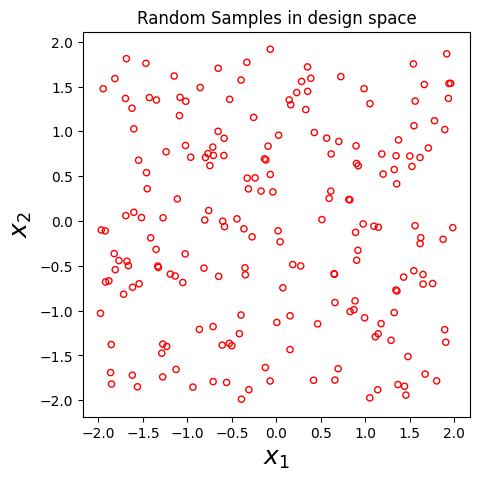

Text(0.5, 1.0, 'Random Samples in objective space')

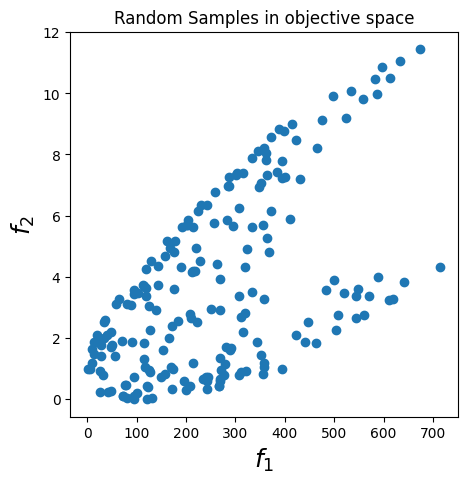

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, n_var=2, n_obj=2, n_constr=2, xl=np.array([-2,-2]), xu=np.array([2,2])):
        super().__init__(n_var=n_var, n_obj=n_obj, n_ieq_constr=n_constr, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]

n_var = 2 # number of variables
xl = np.array([-2,-2]) # lower bounds of x1 and x2
xu = np.array([2,2]) # upper bounds of x1 and x2
n_obj = 2 # number of objectives
n_constr = 2 # number of constraints
problem = MyProblem(n_var=n_var, n_obj=n_obj, n_constr=n_constr, xl=xl, xu=xu)

# Lets run some points and plkot it, 

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util import plotting

sampling = FloatRandomSampling()

samples = sampling(problem, 200)
X = samples.get("X")
F = problem.evaluate(X, return_values_of=["F"])
plt.figure(figsize=(5,5))
fig = plotting.plot(X, show=False, no_fill=True)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)
plt.title("Random Samples in design space")
plt.show()

plt.figure(figsize=(5,5))
fig2 = plotting.plot(F, show=False, no_fill=False)
plt.xlabel("$f_1$", fontsize=18)
plt.ylabel("$f_2$", fontsize=18)
plt.title("Random Samples in objective space")

## Initialize an Algorithm



In [17]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


## Define a Termination Criterion

In [18]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 50)


In [19]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  2.363992E+01 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |  1.239636E+01 |  0.000000E+00 |             f
     3 |       60 |      2 |  0.000000E+00 |  5.4620972973 |  1.0000000000 |         ideal
     4 |       70 |      2 |  0.000000E+00 |  2.3938570636 |  0.000000E+00 |             f
     5 |       80 |      2 |  0.000000E+00 |  1.1200787779 |  0.000000E+00 |             f
     6 |       90 |      3 |  0.000000E+00 |  0.1858089725 |  0.1785481247 |             f
     7 |      100 |      4 |  0.000000E+00 |  0.0096392745 |  0.0639961700 |         ideal
     8 |      110 |      5 |  0.000000E+00 |  0.0016302512 |  0.0912676400 |         ideal
     9 |      120 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1217555949 |         ideal
    10 |      130 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0038809178 |             f

## Analysis of Results

### Let us visualize the final iteration now



In [20]:
import plotly.express as px
xl, xu = problem.bounds()
fig = px.scatter(x=X[:, 0], y=X[:, 1], labels={'x': 'x1', 'y': 'x2'}, title='Design Space')
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='red')))
fig.update_layout(xaxis_range=[xl[0], xu[0]], yaxis_range=[xl[1], xu[1]])
fig.update_layout(width=800, height=600)
fig.show()


In [21]:
fig = px.scatter(x=F[:, 0], y=F[:, 1], labels={'x': 'f1', 'y': 'f2'}, title='Objective Space')
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='red')))
fig.update_layout(xaxis_range= [min(F[:, 0])-0.1, max(F[:, 0])+0.1], yaxis_range=[min(F[:, 1])-0.1, max(F[:, 1])+0.1])
fig.update_layout(width=800, height=600)
fig.show()

### Let us now track how the entire population moved through each iteration



In [22]:
# Making a animation of evolution
import pandas as pd
import plotly.express as px
obj1 = []
obj2 = []
calls = []
for r in res.history:

    objs = r.pop.get("F")
    obj1.extend(objs[:, 0])
    obj2.extend(objs[:, 1])
    calls.extend([r.n_gen]*len(objs))
df = pd.DataFrame(data = {"F1": obj1, "F2": obj2, "n_gen": calls})

obj_fig = px.scatter(df, x="F1", y="F2",
                        animation_frame="n_gen", color="n_gen",
                        range_x=[0., 600], range_y=[0. , 10.],
                        hover_data = df.columns,
                        width = 800, height = 800)
obj_fig.update(layout_coloraxis_showscale=False)
obj_fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1
obj_fig.update_layout(transition = {'duration': 0.001})
obj_fig.show()

In [23]:
## Tracking hypervolume 

from pymoo.indicators.hv import HV
import plotly.graph_objs as go
ref_point = np.array([2.0, 2.0])

hv_list = []

for gen in res.history:
    hv = HV(ref_point)(gen.pop.get("F"))
    hv_list.append(hv)

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, len(hv_list)+1), y=hv_list, mode='lines+markers'))
fig.update_layout(title='Hypervolume Tracking', xaxis_title='Generation', yaxis_title='Hypervolume')

fig.show()

print ("Hypervolume at the end of the optimization: ", hv_list[-1])


Hypervolume at the end of the optimization:  1.202491880477914


In [24]:
# A parallel plot of design adn objective space

import plotly.graph_objects as go

X = res.pop.get("X")
F = res.pop.get("F")

fig = go.Figure(data=go.Parcoords(
    line=dict(color=F[:, 0],
          colorscale='Viridis',
          showscale=True,
          reversescale=True),
    dimensions=list([
        dict(range=[-2, 2],
         label='X1', values=X[:, 0]),
        dict(range=[-2, 2],
         label='X2', values=X[:, 1]),
        dict(range=[0, 250],
         label='F1', values=F[:, 0]),
        dict(range=[0, 1.5],
         label='F2', values=F[:, 1])
    ])
    ))
fig.update_layout(title = "Parallel plot of design space and objective space", 
                  template='plotly_dark')
fig.show()

---

### Exercise 

- Can we visualize the design parameters and how it is correlated to the objectives?
- Can we do a post analysis to decide on a point? May be better suited for Toy Problem?

